# Notebook 3 - Feature Engineering

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 6

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import time
import os
import pyarrow
import gc

# Model evaluation
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import mutual_info_classif

# Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# Plotting
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [3]:
def get_data():
    try:
        #
        original = pd.read_feather('../data/original.feather')
    except:
        # Get Original Data
        original = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz', header = None)

        # Fix columns
        original.columns = ['Elevation', 'Aspect', 'Slope',
               'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
               'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
               'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
               'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
               'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
               'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
               'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
               'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
               'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
               'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
               'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
               'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
               'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
               'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40',
               'Cover_Type']

        for col, dtype in original.dtypes.iteritems():
            if dtype.name.startswith('int'):
                original[col] = pd.to_numeric(original[col], downcast ='integer')
            elif dtype.name.startswith('float'):
                original[col] = pd.to_numeric(original[col], downcast ='float')
        
        if not os.path.isdir('../data'):
            os.mkdir('../data')
        original.to_feather('../data/original.feather')
    return original

In [4]:
%%time
original = get_data()

# Get feature columns
features = [x for x in original.columns if x not in ['Id','Cover_Type']]
wilderness_cols = [x for x in features if x.startswith('Wild')]
soil_cols = [x for x in features if x.startswith('Soil')]
binary_cols = [x for x in features if x.startswith('Soil') or x in wilderness_cols]
numerical_cols = [x for x in features if x not in binary_cols]

# Encoder
old_encoder = LabelEncoder()
original["Cover_Type"] = old_encoder.fit_transform(original["Cover_Type"])

# Data structures for summary scores
new_rows = list()
old_rows = list()

Wall time: 49 ms


# Scoring Features

In [5]:
# Scoring/Training Baseline Function
def train_cv(processing = None):
    
    print(f'\n{NUM_FOLDS}-fold Cross-Validation\n')
    
    # Store the holdout predictions
    oof_preds = np.zeros((original.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(original, original['Cover_Type'])):
        
        # Training and Validation Sets
        X_train = original[features].iloc[train_idx]
        X_valid = original[features].iloc[valid_idx]
        y_train = original['Cover_Type'].iloc[train_idx]
        y_valid = original['Cover_Type'].iloc[valid_idx]
        
        # Feature Engineering
        if processing:
            X_train = processing(X_train)
            X_valid = processing(X_valid)
        
        # Create model
        start = time.time()
        model = XGBClassifier(
            booster = 'gbtree',
            tree_method = 'hist',
            eval_metric = 'mlogloss',
            random_state = RANDOM_SEED,
        )
        model.fit(X_train, y_train)
        
        # validation predictions
        valid_preds = np.ravel(model.predict(X_valid))
        oof_preds[valid_idx] = valid_preds
        
        # fold auc score
        fold_acc = accuracy_score(y_valid, valid_preds)
        end = time.time()
        print(f'Fold {fold} Accuracy:  {round(fold_acc, 5)} in {round(end-start,2)}s.')
        scores[fold] = fold_acc
        times[fold] = end-start
        
        time.sleep(0.5)
        
    print("\nAverage Accuracy:", round(scores.mean(), 5))
    print("Worst Accuracy:", round(scores.min(), 5))
    print(f'Training Time: {round(times.sum(), 2)}s\n')
    
    # Plot confusion matrix
    fig, ax = plt.subplots(figsize = (8,6))
    cm = confusion_matrix(original['Cover_Type'], oof_preds, normalize = 'true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax = ax)
    plt.title("Confusion Matrix (% of Actual Labels)", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("Actual Labels", fontsize=14)
    plt.show()
    
    return scores.mean(), oof_preds

In [6]:
def train_original(processing = None):
    
    print('\nOriginal Train/Test Split')
    
    # Store the holdout predictions
    oof_preds = np.zeros((original.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    
    # Training and Validation Sets
    X_train = original[features].iloc[:15119]
    X_test = original[features].iloc[15119:]
    y_train = original['Cover_Type'].iloc[:15119]
    y_test = original['Cover_Type'].iloc[15119:]
    
    # Feature Engineering
    if processing:
        X_train = processing(X_train)
        X_test = processing(X_test)
        
    # Create model
    start = time.time()
    model = XGBClassifier(
        booster = 'gbtree',
        tree_method = 'hist',
        eval_metric = 'mlogloss',
        random_state = RANDOM_SEED,
    )
    model.fit(X_train, y_train)
        
    # validation and test predictions
    test_preds = np.ravel(model.predict(X_test))
    accuracy = accuracy_score(y_test, test_preds)
    end = time.time()        
    time.sleep(0.5)
    
    print("\nAccuracy:", round(accuracy, 5))
    print(f'Training Time: {round(end-start, 2)}s\n')
    
    # Plot confusion matrix
    fig, ax = plt.subplots(figsize = (8,6))
    cm = confusion_matrix(y_test, test_preds, normalize = 'true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax = ax)
    plt.title("Confusion Matrix (% of Actual Labels)", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("Actual Labels", fontsize=14)
    plt.show()
    
    return accuracy, test_preds

# General Feature Engineering

## 1. XGBoost Baseline


6-fold Cross-Validation

Fold 0 Accuracy:  0.87037 in 13.02s.
Fold 1 Accuracy:  0.86844 in 12.9s.
Fold 2 Accuracy:  0.86851 in 12.94s.
Fold 3 Accuracy:  0.86715 in 13.16s.
Fold 4 Accuracy:  0.86888 in 12.93s.
Fold 5 Accuracy:  0.87122 in 13.1s.

Average Accuracy: 0.86909
Worst Accuracy: 0.86715
Training Time: 78.06s



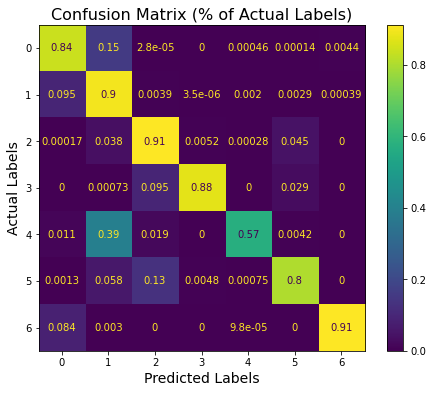

In [7]:
# Cross-validation Baseline
cv_score, oof_preds = train_cv()

new_rows.append((
    'Baseline', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))


Original Train/Test Split

Accuracy: 0.73655
Training Time: 2.04s



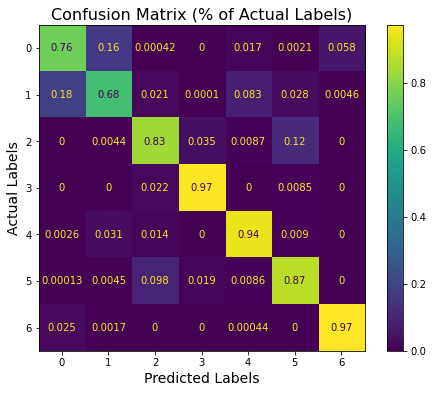

In [8]:
# Train/Test split
test_score, oof_preds = train_original()

old_rows.append((
    'Baseline', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 2. Fix Aspect Range

In [9]:
# Fix aspect
def fix_aspect(data):
    df = data.copy()
    df["Aspect"][df["Aspect"] < 0] += 360
    df["Aspect"][df["Aspect"] > 359] -= 360
    return df


6-fold Cross-Validation

Fold 0 Accuracy:  0.87047 in 12.95s.
Fold 1 Accuracy:  0.86921 in 12.99s.
Fold 2 Accuracy:  0.8699 in 12.95s.
Fold 3 Accuracy:  0.86861 in 12.87s.
Fold 4 Accuracy:  0.86585 in 12.9s.
Fold 5 Accuracy:  0.87229 in 12.96s.

Average Accuracy: 0.86939
Worst Accuracy: 0.86585
Training Time: 77.62s



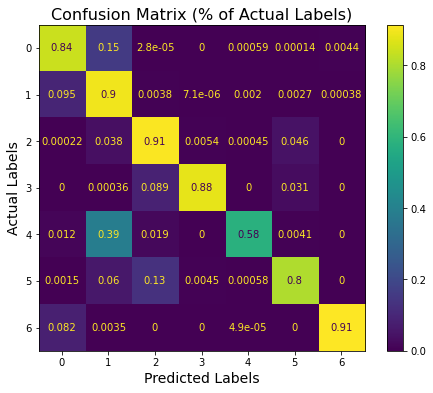

In [10]:
# Cross-validation
cv_score, oof_preds = train_cv(fix_aspect)

new_rows.append((
    'Fix_Aspect', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))


Original Train/Test Split

Accuracy: 0.73695
Training Time: 2.03s



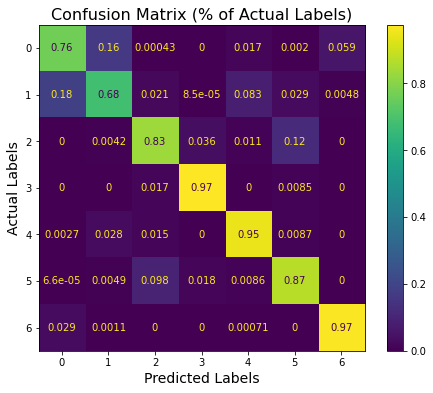

In [11]:
# Train/Test split
test_score, oof_preds = train_original(fix_aspect)

old_rows.append((
    'Fix_Aspect', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 3. Fix Hillshade Range

In [12]:
# Fix Hillshade
def fix_hillshade(data):
    df = data.copy()
    df.loc[df["Hillshade_9am"] < 0, "Hillshade_9am"] = 0
    df.loc[df["Hillshade_Noon"] < 0, "Hillshade_Noon"] = 0
    df.loc[df["Hillshade_3pm"] < 0, "Hillshade_3pm"] = 0
    df.loc[df["Hillshade_9am"] > 255, "Hillshade_9am"] = 255
    df.loc[df["Hillshade_Noon"] > 255, "Hillshade_Noon"] = 255
    df.loc[df["Hillshade_3pm"] > 255, "Hillshade_3pm"] = 255
    return df


6-fold Cross-Validation

Fold 0 Accuracy:  0.87037 in 12.96s.
Fold 1 Accuracy:  0.86844 in 13.12s.
Fold 2 Accuracy:  0.86851 in 13.15s.
Fold 3 Accuracy:  0.86715 in 12.95s.
Fold 4 Accuracy:  0.86888 in 13.12s.
Fold 5 Accuracy:  0.87122 in 13.03s.

Average Accuracy: 0.86909
Worst Accuracy: 0.86715
Training Time: 78.35s



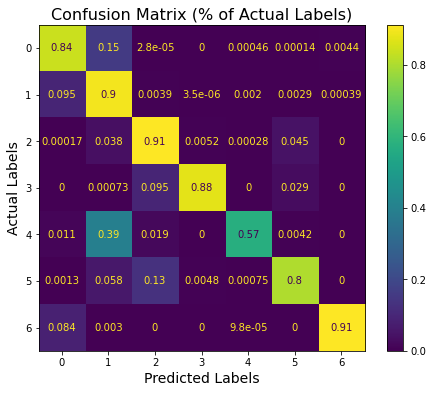

In [13]:
# Cross-validation
cv_score, oof_preds = train_cv(fix_hillshade)

new_rows.append((
    'Fix_Hillshade', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))


Original Train/Test Split

Accuracy: 0.73655
Training Time: 2.05s



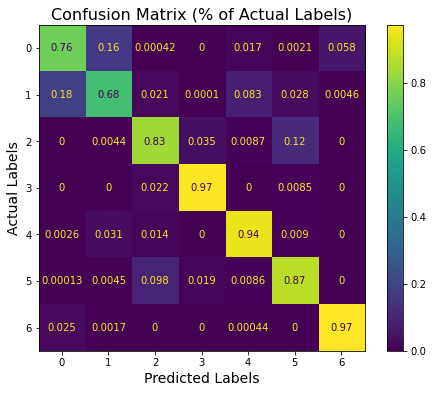

In [14]:
# Train/Test split
test_score, oof_preds = train_original(fix_hillshade)

old_rows.append((
    'Fix_Hillshade', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 4. Water Distance Features

In [15]:
def water_distance_features(data):
    df = data.copy()
    df["Hydro_Taxicab"] = np.abs(df["Horizontal_Distance_To_Hydrology"]) + np.abs(df["Vertical_Distance_To_Hydrology"])
    df["Hydro_Euclid"] = (df["Horizontal_Distance_To_Hydrology"]**2 + df["Vertical_Distance_To_Hydrology"]**2)**0.5
    return df


6-fold Cross-Validation

Fold 0 Accuracy:  0.87208 in 19.35s.
Fold 1 Accuracy:  0.87054 in 18.75s.
Fold 2 Accuracy:  0.86997 in 18.65s.
Fold 3 Accuracy:  0.8706 in 18.85s.
Fold 4 Accuracy:  0.86926 in 18.99s.
Fold 5 Accuracy:  0.87184 in 18.8s.

Average Accuracy: 0.87072
Worst Accuracy: 0.86926
Training Time: 113.4s



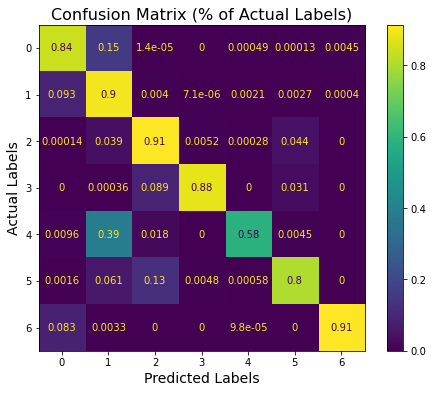

In [16]:
# Cross-validation
cv_score, oof_preds = train_cv(water_distance_features)

new_rows.append((
    'Water_Dist', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))


Original Train/Test Split

Accuracy: 0.73189
Training Time: 2.41s



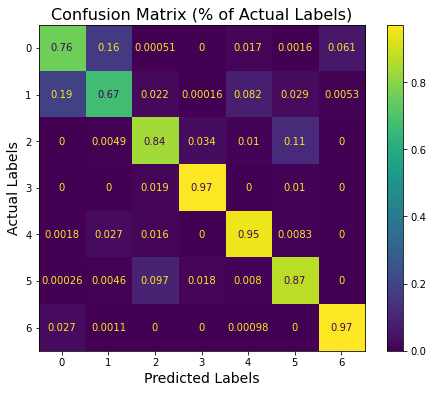

In [17]:
# Train/Test split
test_score, oof_preds = train_original(water_distance_features)

old_rows.append((
    'Water_Dist', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 5. Shade Features

In [18]:
def new_shade_features(data):
    df = data.copy()
    shade_features = ['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']
    df["Hillshade_Avg"] = df[shade_features].mean(axis=1)
    df['Hillshade_Range'] = df[shade_features].max(axis=1) - df[shade_features].min(axis=1)
    return df


6-fold Cross-Validation

Fold 0 Accuracy:  0.8721 in 13.63s.
Fold 1 Accuracy:  0.8683 in 13.63s.
Fold 2 Accuracy:  0.86698 in 13.49s.
Fold 3 Accuracy:  0.8718 in 13.56s.
Fold 4 Accuracy:  0.87132 in 16.92s.
Fold 5 Accuracy:  0.87007 in 14.74s.

Average Accuracy: 0.8701
Worst Accuracy: 0.86698
Training Time: 85.97s



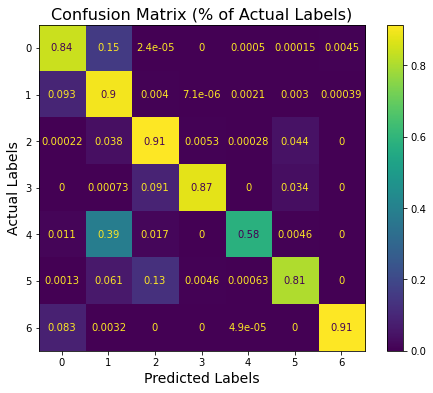

In [19]:
# Cross-validation
cv_score, oof_preds = train_cv(new_shade_features)

new_rows.append((
    'Shade_Features', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))


Original Train/Test Split

Accuracy: 0.73118
Training Time: 2.2s



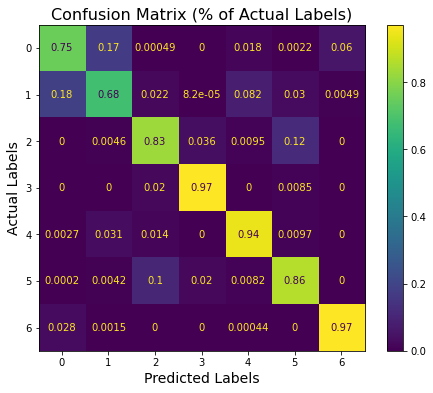

In [20]:
# Train/Test split
test_score, oof_preds = train_original(new_shade_features)

old_rows.append((
    'Shade_Features', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 6. Distance Interactions

In [21]:
def distance_interactions(data):
    df = data.copy()
    df['Hydro_Fire_1'] = df['Horizontal_Distance_To_Hydrology'] + df['Horizontal_Distance_To_Fire_Points']
    df['Hydro_Fire_2'] = abs(df['Horizontal_Distance_To_Hydrology'] - df['Horizontal_Distance_To_Fire_Points'])
    df['Hydro_Road_1'] = abs(df['Horizontal_Distance_To_Hydrology'] + df['Horizontal_Distance_To_Roadways'])
    df['Hydro_Road_2'] = abs(df['Horizontal_Distance_To_Hydrology'] - df['Horizontal_Distance_To_Roadways'])
    df['Fire_Road_1'] = abs(df['Horizontal_Distance_To_Fire_Points'] + df['Horizontal_Distance_To_Roadways'])
    df['Fire_Road_2'] = abs(df['Horizontal_Distance_To_Fire_Points'] - df['Horizontal_Distance_To_Roadways'])
    return df


6-fold Cross-Validation

Fold 0 Accuracy:  0.89398 in 14.55s.
Fold 1 Accuracy:  0.88957 in 14.43s.
Fold 2 Accuracy:  0.89183 in 14.39s.
Fold 3 Accuracy:  0.89124 in 14.55s.
Fold 4 Accuracy:  0.88952 in 14.37s.
Fold 5 Accuracy:  0.89067 in 14.41s.

Average Accuracy: 0.89113
Worst Accuracy: 0.88952
Training Time: 86.71s



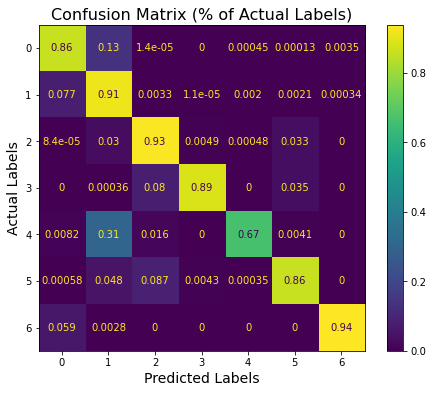

In [22]:
# Cross-validation
cv_score, oof_preds = train_cv(distance_interactions)

new_rows.append((
    'Dist_Interactions', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))


Original Train/Test Split

Accuracy: 0.75954
Training Time: 2.4s



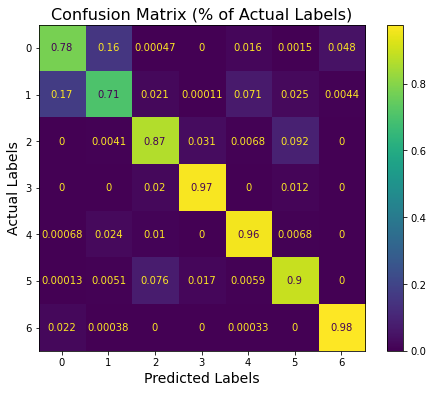

In [23]:
# Train/Test split
test_score, oof_preds = train_original(distance_interactions)

old_rows.append((
    'Dist_Interactions', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 8. Misc. Interactions

In [24]:
def various_interactions(data):
    df = data.copy()
    df['EHiElv'] = df['Horizontal_Distance_To_Roadways'] * df['Elevation']
    df['EViElv'] = df['Vertical_Distance_To_Hydrology'] * df['Elevation']
    df['Highwater'] = (df.Vertical_Distance_To_Hydrology < 0).astype(int)
    df['EVDtH'] = df.Elevation - df.Vertical_Distance_To_Hydrology
    df['EHDtH'] = df.Elevation - df.Horizontal_Distance_To_Hydrology * 0.2
    df['Hillshade_3pm_is_zero'] = (df.Hillshade_3pm == 0).astype(int)
    return df


6-fold Cross-Validation

Fold 0 Accuracy:  0.8821 in 14.02s.
Fold 1 Accuracy:  0.88113 in 14.05s.
Fold 2 Accuracy:  0.88266 in 14.12s.
Fold 3 Accuracy:  0.8822 in 13.98s.
Fold 4 Accuracy:  0.87947 in 13.99s.
Fold 5 Accuracy:  0.88072 in 14.18s.

Average Accuracy: 0.88138
Worst Accuracy: 0.87947
Training Time: 84.34s



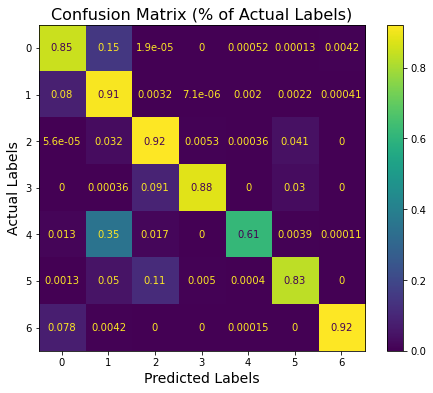

In [25]:
# Cross-validation
cv_score, oof_preds = train_cv(various_interactions)

new_rows.append((
    'Misc_Interactions', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))


Original Train/Test Split

Accuracy: 0.73492
Training Time: 2.33s



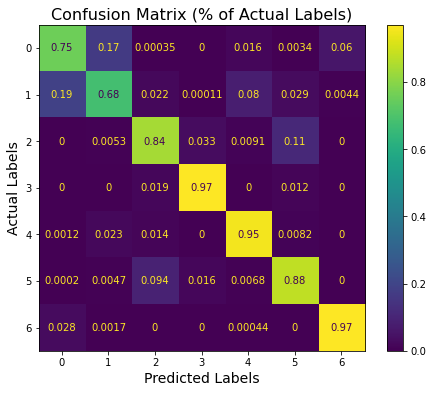

In [26]:
# Train/Test split
test_score, oof_preds = train_original(various_interactions)

old_rows.append((
    'Misc_Interactions', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## Summary 

In [27]:
pd.DataFrame.from_records(
    data = new_rows,
    columns = ['model','cv_scores','recall_0','recall_1','recall_2','recall_3','recall_4','recall_5','recall_6']
).sort_values('cv_scores')

,model,cv_scores,recall_0,recall_1,recall_2,recall_3,recall_4,recall_5,recall_6
0,Baseline,0.869094,0.839955,0.896220,0.911339,0.875501,0.572948,0.804572,0.912579
2,Fix_Hillshade,0.869094,0.839955,0.896220,0.911339,0.875501,0.572948,0.804572,0.912579
1,Fix_Aspect,0.869390,0.840262,0.896276,0.910863,0.880233,0.579269,0.804342,0.914481
4,Shade_Features,0.870096,0.840502,0.897349,0.912318,0.874772,0.579690,0.805723,0.913993
3,Water_Dist,0.870719,0.841276,0.898119,0.911702,0.879141,0.582113,0.804399,0.913506
6,Misc_Interactions,0.881379,0.846360,0.912044,0.921240,0.878777,0.613610,0.830138,0.917699
5,Dist_Interactions,0.891133,0.860942,0.914783,0.931141,0.885329,0.665964,0.860022,0.937884


In [28]:
pd.DataFrame.from_records(
    data = old_rows,
    columns = ['model','accuracy','recall_0','recall_1','recall_2','recall_3','recall_4','recall_5','recall_6']
).sort_values('accuracy')

,model,accuracy,recall_0,recall_1,recall_2,recall_3,recall_4,recall_5,recall_6
4,Shade_Features,0.731182,0.751650,0.675437,0.829111,0.971039,0.942997,0.863878,0.969809
3,Water_Dist,0.731895,0.756519,0.671688,0.836940,0.971039,0.947089,0.871835,0.971008
6,Misc_Interactions,0.734918,0.754698,0.678460,0.838726,0.969336,0.953498,0.878411,0.970082
0,Baseline,0.736546,0.760220,0.678699,0.833785,0.969336,0.942997,0.870652,0.973188
2,Fix_Hillshade,0.736546,0.760220,0.678699,0.833785,0.969336,0.942997,0.870652,0.973188
1,Fix_Aspect,0.736954,0.761813,0.678674,0.832922,0.974446,0.946134,0.869665,0.968937
5,Dist_Interactions,0.759538,0.778210,0.705692,0.866081,0.967632,0.958544,0.895969,0.976839


# Soil Type Features

Next, were going to attempt to leverage domain knowledge to derive further categorical features using the soil types. From the description of the dataset, we have the following:
```
     ID    Code     Description

     1     2702     Cathedral family - Rock outcrop complex, extremely stony.
     2     2703     Vanet - Ratake families complex, very stony.
     3     2704     Haploborolis - Rock outcrop complex, rubbly.
     4     2705     Ratake family - Rock outcrop complex, rubbly.
     5     2706     Vanet family - Rock outcrop complex complex, rubbly.
     6     2717     Vanet - Wetmore families - Rock outcrop complex, stony.
     7     3501     Gothic family.
     8     3502     Supervisor - Limber families complex.
     9     4201     Troutville family, very stony.
    10     4703     Bullwark - Catamount families - Rock outcrop complex, rubbly.
    11     4704     Bullwark - Catamount families - Rock land complex, rubbly.
    12     4744     Legault family - Rock land complex, stony.
    13     4758     Catamount family - Rock land - Bullwark family complex, rubbly.
    14     5101     Pachic Argiborolis - Aquolis complex.
    15     5151     unspecified in the USFS Soil and ELU Survey.
    16     6101     Cryaquolis - Cryoborolis complex.
    17     6102     Gateview family - Cryaquolis complex.
    18     6731     Rogert family, very stony.
    19     7101     Typic Cryaquolis - Borohemists complex.
    20     7102     Typic Cryaquepts - Typic Cryaquolls complex.
    21     7103     Typic Cryaquolls - Leighcan family, till substratum complex.
    22     7201     Leighcan family, till substratum, extremely bouldery.
    23     7202     Leighcan family, till substratum - Typic Cryaquolls complex.
    24     7700     Leighcan family, extremely stony.
    25     7701     Leighcan family, warm, extremely stony.
    26     7702     Granile - Catamount families complex, very stony.
    27     7709     Leighcan family, warm - Rock outcrop complex, extremely stony.
    28     7710     Leighcan family - Rock outcrop complex, extremely stony.
    29     7745     Como - Legault families complex, extremely stony.
    30     7746     Como family - Rock land - Legault family complex, extremely stony.
    31     7755     Leighcan - Catamount families complex, extremely stony.
    32     7756     Catamount family - Rock outcrop - Leighcan family complex, extremely stony.
    33     7757     Leighcan - Catamount families - Rock outcrop complex, extremely stony.
    34     7790     Cryorthents - Rock land complex, extremely stony.
    35     8703     Cryumbrepts - Rock outcrop - Cryaquepts complex.
    36     8707     Bross family - Rock land - Cryumbrepts complex, extremely stony.
    37     8708     Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.
    38     8771     Leighcan - Moran families - Cryaquolls complex, extremely stony.
    39     8772     Moran family - Cryorthents - Leighcan family complex, extremely stony.
    40     8776     Moran family - Cryorthents - Rock land complex, extremely stony.

        Note:   First digit:  climatic zone             Second digit:  geologic zones
                1.  lower montane dry                   1.  alluvium
                2.  lower montane                       2.  glacial
                3.  montane dry                         3.  shale
                4.  montane                             4.  sandstone
                5.  montane dry and montane             5.  mixed sedimentary
                6.  montane and subalpine               6.  unspecified in the USFS ELU Survey
                7.  subalpine                           7.  igneous and metamorphic
                8.  alpine                              8.  volcanic

        The third and fourth ELU digits are unique to the mapping unit 
        and have no special meaning to the climatic or geologic zones.
```

In [29]:
# Dictionary for mapping to ELU Code
code = {
    1:2702,2:2703,3:2704,4:2705,5:2706,
    6:2717,7:3501,8:3502,9:4201,10:4703,
    11:4704,12:4744,13:4758,14:5101,15:5151,
    16:6101,17:6102,18:6731,19:7101,20:7102,
    21:7103,22:7201,23:7202,24:7700,25:7701,
    26:7702,27:7709,28:7710,29:7745,30:7746,
    31:7755,32:7756,33:7757,34:7790,35:8703,
    36:8707,37:8708,38:8771,39:8772,40:8776
}

## 1. Undo One-Hot Encoding

In [30]:
def consolidate_soil_types(input_df):
    data = input_df.copy()
    soil_features = sorted([x for x in data.columns if x.startswith("Soil_Type")])
    soil_type = list()
    for index, row in data[soil_features].iterrows():
        found = False
        for i, val in enumerate(row, start = 1):
            if val != 0:
                soil_type.append(i)
                found = True
                break
        if not found: soil_type.append(None)
    data['Soil_Type'] = soil_type
    nonsoil_features = [x for x in data.columns if x not in soil_features]
    return data[nonsoil_features]


6-fold Cross-Validation

Fold 0 Accuracy:  0.87783 in 8.72s.
Fold 1 Accuracy:  0.87727 in 8.65s.
Fold 2 Accuracy:  0.87367 in 8.63s.
Fold 3 Accuracy:  0.87719 in 8.72s.
Fold 4 Accuracy:  0.87631 in 8.62s.
Fold 5 Accuracy:  0.87576 in 8.64s.

Average Accuracy: 0.87634
Worst Accuracy: 0.87367
Training Time: 51.99s



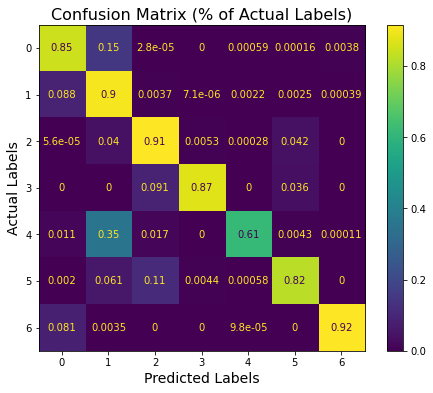

In [31]:
# Cross-validation
cv_score, oof_preds = train_cv(consolidate_soil_types)

new_rows.append((
    'Ordinal_Encoding', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))


Original Train/Test Split

Accuracy: 0.73899
Training Time: 1.48s



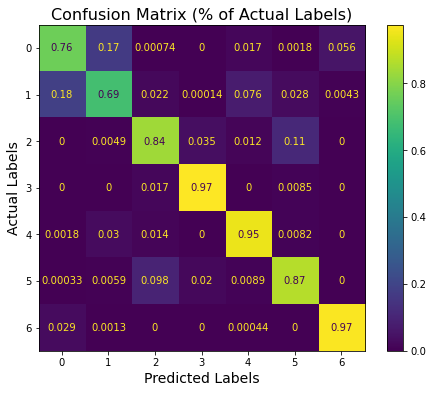

In [32]:
# Train/Test split
test_score, oof_preds = train_original(consolidate_soil_types)

old_rows.append((
    'Ordinal_Encoding', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 2. Climatic Zone

We create a feature based on the climatic zone of the soil, which has a natural ordering:

1. lower montane dry
2. lower montane
3. montane dry
4. montane
5. montane dry and montane
6. montane and subalpine
7. subalpine
8. alpine

However, the ordering of the soil type labels roughly follows the ordering of their respectively climatic zones, so there's a chance this feature won't be particularly informative.

In [33]:
def climatic_zone_original(input_df):
    data = input_df.copy()
    data = consolidate_soil_types(data)
    data['Climatic Zone'] = data['Soil_Type'].apply(lambda x: int(str(code[x])[0]))
    return data


6-fold Cross-Validation

Fold 0 Accuracy:  0.87783 in 8.75s.
Fold 1 Accuracy:  0.87727 in 8.67s.
Fold 2 Accuracy:  0.87367 in 8.7s.
Fold 3 Accuracy:  0.87719 in 8.72s.
Fold 4 Accuracy:  0.87631 in 8.73s.
Fold 5 Accuracy:  0.87576 in 8.68s.

Average Accuracy: 0.87634
Worst Accuracy: 0.87367
Training Time: 52.25s



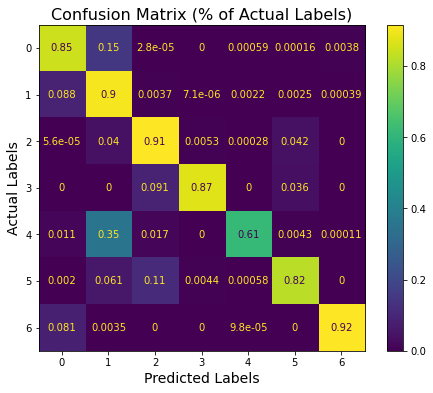

In [34]:
# Cross-validation
cv_score, oof_preds = train_cv(climatic_zone_original)

new_rows.append((
    'Climatic_Zone', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))


Original Train/Test Split

Accuracy: 0.73899
Training Time: 1.49s



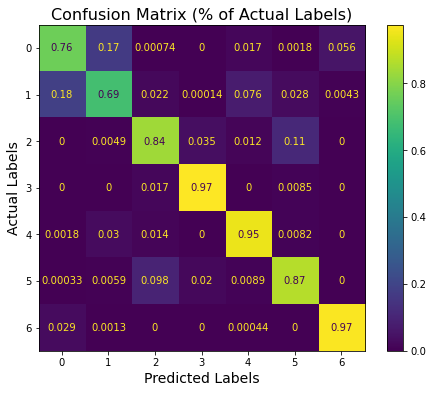

In [35]:
# Train/Test split
test_score, oof_preds = train_original(climatic_zone_original)

old_rows.append((
    'Climatic_Zone', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 3. Geologic Zones

1. alluvium
2. glacial
3. shale
4. sandstone
5. mixed sedimentary
6. unspecified in the USFS ELU Survey
7. igneous and metamorphic
8. volcanic

This is another feature which is based on the soil type codes.

In [36]:
def geologic_zone_original(input_df):
    data = input_df.copy()
    data = consolidate_soil_types(data)
    data['Geologic_Zone'] = data['Soil_Type'].apply(lambda x: int(str(code[x])[1]))
    return data


6-fold Cross-Validation

Fold 0 Accuracy:  0.87724 in 8.68s.
Fold 1 Accuracy:  0.87521 in 8.72s.
Fold 2 Accuracy:  0.87494 in 8.68s.
Fold 3 Accuracy:  0.87478 in 8.69s.
Fold 4 Accuracy:  0.87491 in 8.69s.
Fold 5 Accuracy:  0.87828 in 8.7s.

Average Accuracy: 0.87589
Worst Accuracy: 0.87478
Training Time: 52.17s



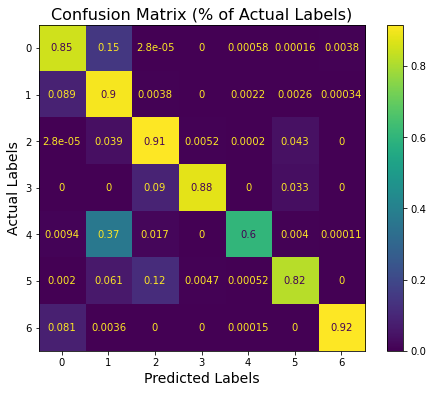

In [37]:
# Cross-validation
cv_score, oof_preds = train_cv(geologic_zone_original)

new_rows.append((
    'Geologic_Zone', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))


Original Train/Test Split

Accuracy: 0.73951
Training Time: 1.49s



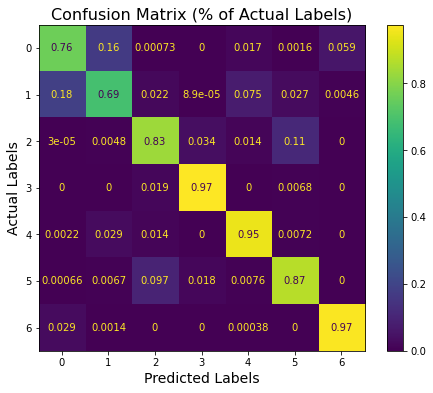

In [38]:
# Train/Test split
test_score, oof_preds = train_original(geologic_zone_original)

old_rows.append((
    'Geologic_Zone', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 4. Surface Cover

According to the [USDA reference](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/soils/ref/?cid=nrcs142p2_054253#surface_fragments) on soil profiling:

1. **(Stony/Bouldery)** — Stones or boulders cover 0.01 to less than 0.1 percent of the surface. The smallest stones are at least 8 meters apart; the smallest boulders are at least 20 meters apart (fig. 3-9).

2. **(Very Stony/Very Bouldery)** — Stones or boulders cover 0.1 to less than 3 percent of the surface. The smallest stones are not less than 1 meter apart; the smallest boulders are not less than 3 meters apart (fig. 3-10).

3. **(Extremely Stony/Extremely Bouldery)** — Stones or boulders cover 3 to less than 15 percent of the surface. The smallest stones are as little as 0.5 meter apart; the smallest boulders are as little as 1 meter apart (fig. 3-11).

4. **(Rubbly)** — Stones or boulders cover 15 to less than 50 percent of the surface. The smallest stones are as little as 0.3 meter apart; the smallest boulders are as little as 0.5 meter apart. In most places it is possible to step from stone to stone or jump from boulder to boulder without touching the soil (fig. 3-12).

5. **(Very Rubbly)** — Stones or boulders appear to be nearly continuous and cover 50 percent or more of the surface. The smallest stones are less than 0.03 meter apart; the smallest boulders are less than 0.05 meter apart. Classifiable soil is among the rock fragments, and plant growth is possible (fig. 3-13).

In [39]:
# Group IDs
no_desc = [7,8,14,15,16,17,19,20,21,23,35]
stony = [6,12]
very_stony = [2,9,18,26]
extremely_stony = [1,22,24,25,27,28,29,30,31,32,33,34,36,37,38,39,40]
rubbly = [3,4,5,10,11,13]

# Create dictionary
surface_cover = {i:None for i in no_desc}
surface_cover.update({i:0 for i in stony})
surface_cover.update({i:1 for i in very_stony})
surface_cover.update({i:2 for i in extremely_stony})
surface_cover.update({i:3 for i in rubbly})

# Preprocessing function
def surface_cover_original(input_df):
    data = input_df.copy()
    data = consolidate_soil_types(data)
    data['Surface_Cover'] = data['Soil_Type'].apply(lambda x: surface_cover[x])
    return data


6-fold Cross-Validation

Fold 0 Accuracy:  0.87361 in 11.98s.
Fold 1 Accuracy:  0.87545 in 11.69s.
Fold 2 Accuracy:  0.87352 in 12.33s.
Fold 3 Accuracy:  0.8772 in 11.98s.
Fold 4 Accuracy:  0.87675 in 11.94s.
Fold 5 Accuracy:  0.87508 in 11.9s.

Average Accuracy: 0.87527
Worst Accuracy: 0.87352
Training Time: 71.82s



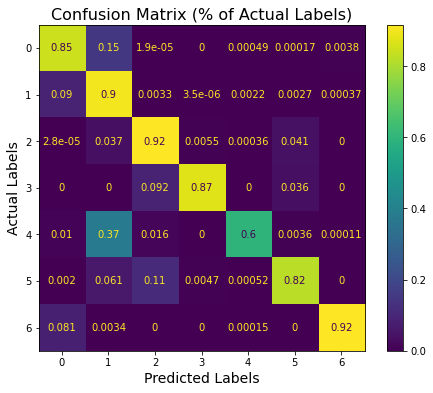

In [40]:
# Cross-validation
cv_score, oof_preds = train_cv(surface_cover_original)

new_rows.append((
    'Surface_Cover', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))


Original Train/Test Split

Accuracy: 0.74064
Training Time: 1.54s



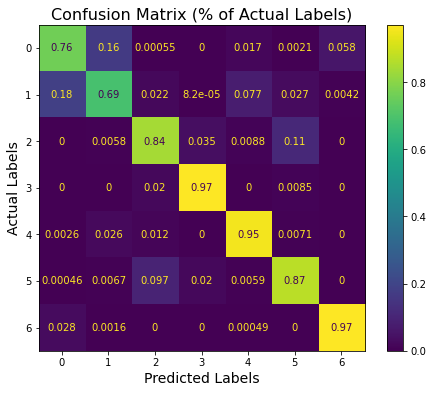

In [41]:
# Train/Test split
test_score, oof_preds = train_original(surface_cover_original)

old_rows.append((
    'Surface_Cover', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 5. Rock Size (Ordinal)

According to the [USDA reference](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/soils/ref/?cid=nrcs142p2_054253#fragments) on soil profile:

* Stones/Stony - 250–600 mm diameter
* Boulders/Bouldery - > 600 mm diameter

We can use these to perhaps derive useful features

In [42]:
# Group IDs
no_desc = [7,8,14,15,16,17,19,20,21,23,35]
stones = [1,2,6,9,12,18,24,25,26,27,28,29,30,31,32,33,34,36,37,38,39,40]
boulders = [22]
rubble = [3,4,5,10,11,13]

# Create dictionary
rock_size = {i:None for i in no_desc}
rock_size.update({i:0 for i in stones})
rock_size.update({i:1 for i in boulders})
rock_size.update({i:2 for i in rubble})

# Preprocessing function
def rock_size_original(input_df):
    data = input_df.copy()
    data = consolidate_soil_types(data)
    data['Rock_Size'] = data['Soil_Type'].apply(lambda x: rock_size[x])
    return data


6-fold Cross-Validation

Fold 0 Accuracy:  0.87377 in 11.93s.
Fold 1 Accuracy:  0.87613 in 11.83s.
Fold 2 Accuracy:  0.87404 in 11.94s.
Fold 3 Accuracy:  0.87729 in 11.98s.
Fold 4 Accuracy:  0.87452 in 11.99s.
Fold 5 Accuracy:  0.87697 in 11.92s.

Average Accuracy: 0.87545
Worst Accuracy: 0.87377
Training Time: 71.59s



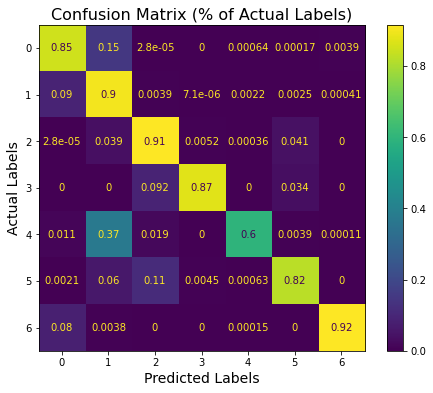

In [43]:
# Cross-validation
cv_score, oof_preds = train_cv(rock_size_original)

new_rows.append((
    'Rock_Size', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))


Original Train/Test Split

Accuracy: 0.73832
Training Time: 1.52s



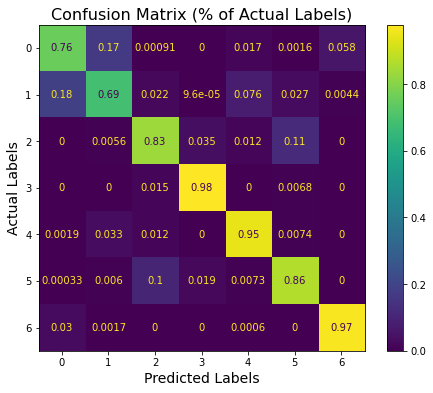

In [44]:
# Train/Test split
test_score, oof_preds = train_original(rock_size_original)

old_rows.append((
    'Rock_Size', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 6. More Description Features

In [45]:
cathedral = []
rock_outcroup = []
rock_land = []
vanet = []
ratake = []
wetmore = []
haploborolis = []
gothic = []
supervisor = []
limber = []
troutville = []
bullwark = []
legault = []
pachic_argiborolis = []
aquolis = []
cryoborolis = []
Cryaquolis = []
Cryaquepts = []
Cryaquolls = []
Cryorthents = []
Cryumbrepts = []
gateview = []
rogert = []
till_substratum = []
granile = []
Catamount = []
Leighcan = []
como = []
catamount = []
Bross = []
Moran = []

# Summary

In [46]:
pd.DataFrame.from_records(
    data = new_rows,
    columns = ['features','cv_scores','recall_0', 'recall_1','recall_2','recall_3','recall_4','recall_5','recall_6']
).sort_values('cv_scores')

,features,cv_scores,recall_0,recall_1,recall_2,recall_3,recall_4,recall_5,recall_6
0,Baseline,0.869094,0.839955,0.896220,0.911339,0.875501,0.572948,0.804572,0.912579
2,Fix_Hillshade,0.869094,0.839955,0.896220,0.911339,0.875501,0.572948,0.804572,0.912579
1,Fix_Aspect,0.869390,0.840262,0.896276,0.910863,0.880233,0.579269,0.804342,0.914481
4,Shade_Features,0.870096,0.840502,0.897349,0.912318,0.874772,0.579690,0.805723,0.913993
3,Water_Dist,0.870719,0.841276,0.898119,0.911702,0.879141,0.582113,0.804399,0.913506
10,Surface_Cover,0.875268,0.846700,0.901119,0.916121,0.871860,0.597177,0.822710,0.915700
11,Rock_Size,0.875452,0.847961,0.900932,0.914415,0.873680,0.595386,0.820752,0.915700
9,Geologic_Zone,0.875892,0.848504,0.901705,0.912429,0.877685,0.602128,0.816088,0.915651
7,Ordinal_Encoding,0.876338,0.846445,0.903477,0.912821,0.872224,0.614347,0.820464,0.915748
8,Climatic_Zone,0.876338,0.846445,0.903477,0.912821,0.872224,0.614347,0.820464,0.915748


In [47]:
pd.DataFrame.from_records(
    data = old_rows,
    columns = ['features','accuracy','recall_0', 'recall_1','recall_2','recall_3','recall_4','recall_5','recall_6']
).sort_values('accuracy')

,features,accuracy,recall_0,recall_1,recall_2,recall_3,recall_4,recall_5,recall_6
4,Shade_Features,0.731182,0.751650,0.675437,0.829111,0.971039,0.942997,0.863878,0.969809
3,Water_Dist,0.731895,0.756519,0.671688,0.836940,0.971039,0.947089,0.871835,0.971008
6,Misc_Interactions,0.734918,0.754698,0.678460,0.838726,0.969336,0.953498,0.878411,0.970082
0,Baseline,0.736546,0.760220,0.678699,0.833785,0.969336,0.942997,0.870652,0.973188
2,Fix_Hillshade,0.736546,0.760220,0.678699,0.833785,0.969336,0.942997,0.870652,0.973188
1,Fix_Aspect,0.736954,0.761813,0.678674,0.832922,0.974446,0.946134,0.869665,0.968937
11,Rock_Size,0.738316,0.755699,0.686282,0.832922,0.977853,0.946543,0.864799,0.968011
7,Ordinal_Encoding,0.738995,0.758332,0.685137,0.836196,0.974446,0.945998,0.867166,0.968774
8,Climatic_Zone,0.738995,0.758332,0.685137,0.836196,0.974446,0.945998,0.867166,0.968774
9,Geologic_Zone,0.739513,0.758236,0.686460,0.832326,0.974446,0.947634,0.870060,0.969591
